In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from trainer.model import build_encoder_decoder, build_refinement
from trainer.test_model import build_test_encoder_decoder, build_test_refinement
from trainer.utils import get_final_output

In [31]:
img_rows, img_cols = 320, 320
channel = 4
#checkpoint = '/Users/erez/Desktop/models_checkpoints_checkpoint.04-0.0373.hdf5'
checkpoint = '../models/final.42-0.0398.hdf5'
image_path = '/Users/erez/Desktop/data/test/carvana/26ccab021981_07.jpg'

#to generate trimap
mask_path = '/Users/erez/Desktop/data/test/carvana/26ccab021981_07_mask.jpg'

encoder_decoder = build_encoder_decoder()
final = build_refinement(encoder_decoder)
final.load_weights(checkpoint)
#print(final.summary())

print('Start processing image: {}'.format(image_path))

x_test = np.empty((1, img_rows, img_cols, 4), dtype=np.float32)
bgr_img = cv.imread(image_path)
trimap = generate_trimap(cv.imread(mask_path,0))

if bgr_img.shape[0] != 320: 
    bgr_img = cv.resize(bgr_img, (img_rows, img_cols))
    trimap = cv.resize(trimap, (img_rows, img_cols))

x_test[0, :, :, 0:3] = bgr_img / 255.
x_test[0, :, :, 3] = trimap / 255.

out = final.predict(x_test)
out = np.reshape(out, (img_rows, img_cols))
print(out.shape)
out = out * 255.0
out = get_final_output(out, trimap)
out = out.astype(np.uint8)

Start processing image: /Users/erez/Desktop/data/test/carvana/26ccab021981_07.jpg
(320, 320)


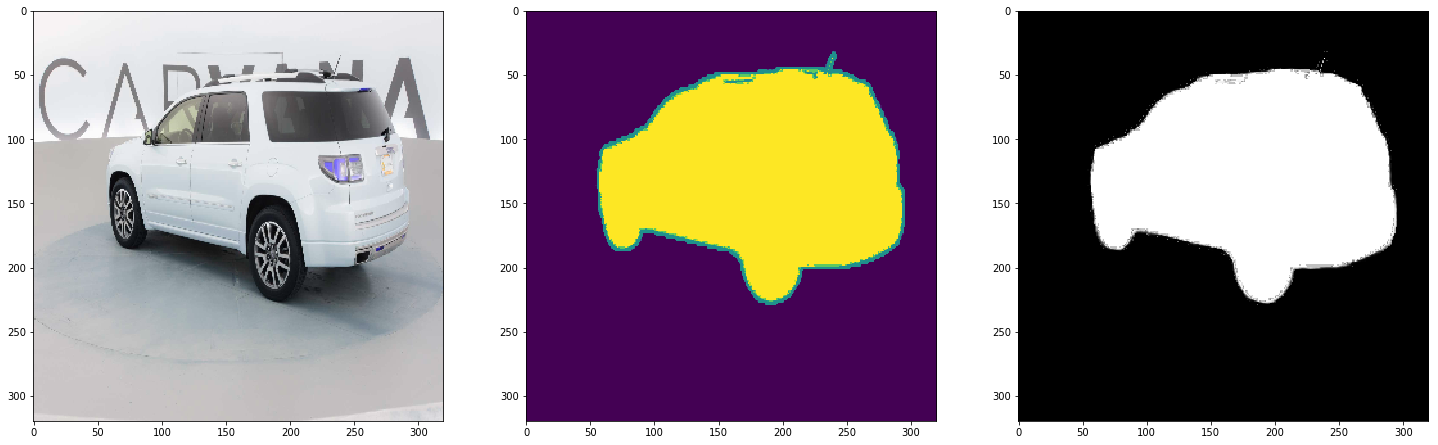

In [32]:
f, ax = plt.subplots(1,3,figsize=(25,25))

ax[0].imshow(bgr_img)
ax[1].imshow(trimap)
ax[2].imshow(out, cmap = 'gray')

In [6]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
def generate_trimap(alpha):
    fg = np.array(np.equal(alpha, 255).astype(np.float32))
    # fg = cv.erode(fg, kernel, iterations=np.random.randint(1, 3))
    unknown = np.array(np.not_equal(alpha, 0).astype(np.float32))
    unknown = cv.dilate(unknown, kernel, iterations=np.random.randint(1, 20))
    trimap = fg * 255 + (unknown - fg) * 128
    return trimap.astype(np.uint8)